# Regression Analyses

This section performs the linear regression on exam score and binary logistic regression on exam pass/fail.

In [41]:
## libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score


## Data Cleaning

In [42]:
## read in data
url = 'https://raw.githubusercontent.com/USD-AAI-500-Stats-Group-2/Stats500FinalProject/main/data/student_habits_performance.csv'

student_habits = pd.read_csv(url)
student_habits.head(15)

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4
5,S1005,24,Male,7.2,1.3,0.0,No,82.9,7.4,Fair,1,Master,Average,4,No,100.0
6,S1006,21,Female,5.6,1.5,1.4,Yes,85.8,6.5,Good,2,Master,Poor,4,No,89.8
7,S1007,21,Female,4.3,1.0,2.0,Yes,77.7,4.6,Fair,0,Bachelor,Average,8,No,72.6
8,S1008,23,Female,4.4,2.2,1.7,No,100.0,7.1,Good,3,Bachelor,Good,1,No,78.9
9,S1009,18,Female,4.8,3.1,1.3,No,95.4,7.5,Good,5,Bachelor,Good,10,Yes,100.0


In [43]:
## identify "None" coded as Nulls
nulls = pd.DataFrame(student_habits.isnull().sum(), columns=['Nulls'])
nulls = nulls[nulls['Nulls']>0]
nulls

## replace with 'None' - decided not to do this, and keep as NA
#student_habits['parental_education_level'] = student_habits['parental_education_level'].fillna('None')

,Nulls
parental_education_level,91


In [44]:
## assign ordered levels for ordinal variables

# gender
student_habits['gender'].value_counts()
student_habits['gender'] = pd.Categorical(student_habits['gender'],
                                          categories = ['Male', 'Female', 'Other'],
                                          ordered = False)

# part time job
student_habits['part_time_job'].value_counts()
student_habits['part_time_job'] = pd.Categorical(student_habits['part_time_job'],
                                          categories = ['No', 'Yes'],
                                          ordered = False)

# diet quality
student_habits['diet_quality'].value_counts()
student_habits['diet_quality'] = pd.Categorical(student_habits['diet_quality'],
                                          categories = ['Poor', 'Fair', 'Good'],
                                          ordered = False)

# parental education level
student_habits['parental_education_level'].value_counts()
# "None" not considered
#student_habits['parental_education_level'] = pd.Categorical(student_habits['parental_education_level'],
#                                          categories = ['None', 'High School', 'Bachelor', 'Master'],
#                                          ordered = False)
student_habits['parental_education_level'] = pd.Categorical(student_habits['parental_education_level'],
                                          categories = ['High School', 'Bachelor', 'Master'],
                                          ordered = False)

# internet quality
student_habits['internet_quality'].value_counts()
student_habits['internet_quality'] = pd.Categorical(student_habits['internet_quality'],
                                          categories = ['Poor', 'Average', 'Good'],
                                          ordered = False)

# extracurricular participation
student_habits['extracurricular_participation'].value_counts()
student_habits['extracurricular_participation'] = pd.Categorical(student_habits['extracurricular_participation'],
                                          categories = ['No', 'Yes'],
                                          ordered = False)

## Linear Regression Analysis
Predicting exam score

### Train Model

In [45]:
#### linear regression with all variables (except student_id)

## identify independent (x) and dependent (y) variables
x = student_habits[['age', 'gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
                    'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency',
                    'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation']]
y = student_habits['exam_score']

## create dummy variables for categorical data
x = pd.get_dummies(x, drop_first = True)

## split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 33)

## add intercept
x_train = sm.add_constant(x_train)

## convert to float variable types
x_train = x_train.astype(float)
y_train = y_train.astype(float)

## train model
model_linear = sm.OLS(y_train, x_train).fit()

## view model
print(model_linear.summary())

                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     395.0
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:04:40   Log-Likelihood:                -2483.1
No. Observations:                 800   AIC:                             5004.
Df Residuals:                     781   BIC:                             5093.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

### Evaluate Linear Regression Goodness of Fit

Use test (unseen) data

In [46]:
### evaluate linear regression

## add constant column to test set
x_test = sm.add_constant(x_test)

## predict y based on x's
y_test_pred = model_linear.predict(x_test)

## view metrics
print('R^2 on test: %.4f' % r2_score(y_test, y_test_pred))

R^2 on test: 0.9032


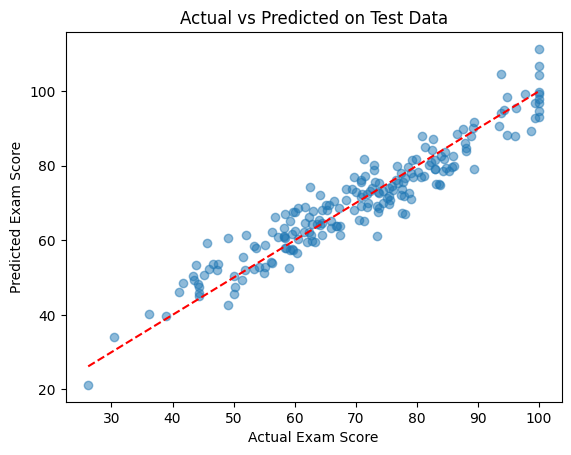

In [47]:
## goodness of fit
plt.scatter(y_test, y_test_pred, alpha = 0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title('Actual vs Predicted on Test Data')
plt.show()

# interpretation: points are close to red dashed line, which indicates good predictions

### Evaluate Linear Regression Model Assumptions

Use test (unseen) data

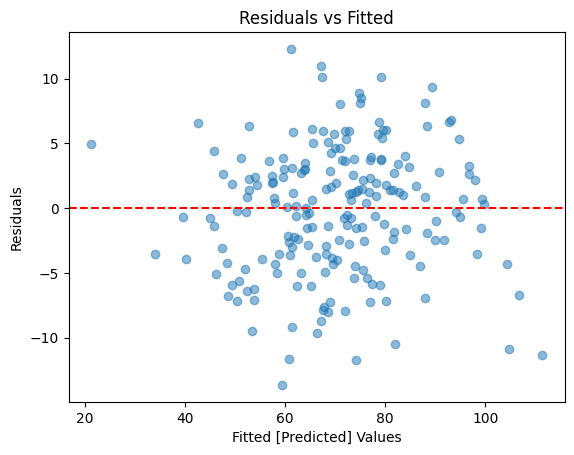

In [48]:
## check for linearity and homoscedasticity
residuals = y_test - y_test_pred

plt.scatter(y_test_pred, residuals, alpha = 0.5)
plt.axhline(0, color = 'red', linestyle = '--')
plt.xlabel('Fitted [Predicted] Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# interpretation: points appear to have random scatter around 0, no concerning patterns

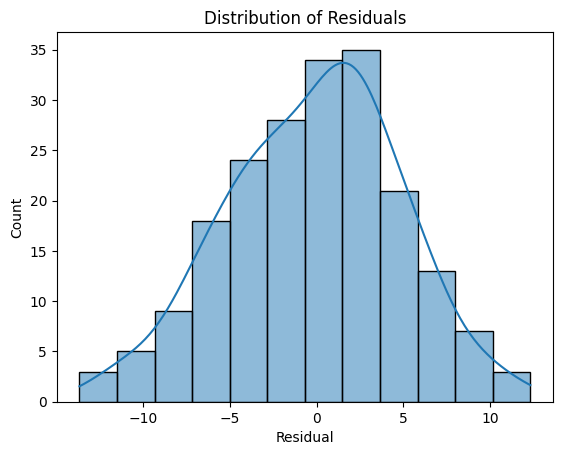

In [49]:
## check for normality of residuals

sns.histplot(residuals, kde = True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.show()

# interpretation: distribution looks roughly bell-shaped, hence residuals are normal

In [50]:
## check for normality of residuals using Shapiro–Wilk test
shapiro_test_residuals = stats.shapiro(residuals)
print(f'Shapiro-Wilk p-value = {shapiro_test_residuals.pvalue:.4f}')

Shapiro-Wilk p-value = 0.6547


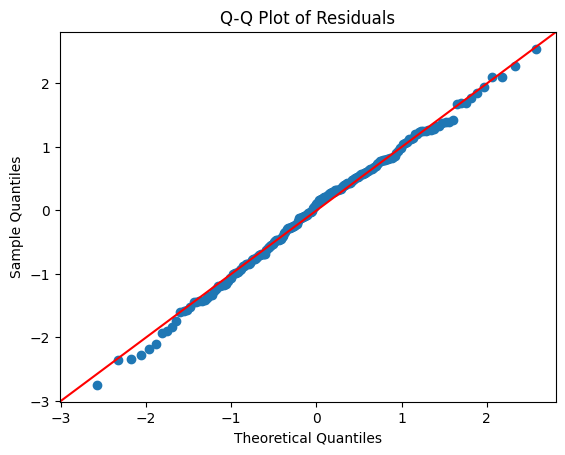

In [51]:
## Q-Q Plot for Residual Normality

residuals = pd.to_numeric(residuals, errors = 'coerce')
sm.qqplot(residuals, line = '45', fit = True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# interpretation: points roughly follow the 45 degree line

## Binary Logistic Regression Analysis

Predicting exam pass (1)  or fail (0)

### Data Preparation

In [52]:
#### change exam_score into pass/fail binary variable

## threshold for pass/fail
pass_threshold = 70

## convert variable
student_habits['pass_fail'] = (pd.to_numeric(student_habits['exam_score'], errors = 'coerce') >= pass_threshold).astype(int)

## view new variable
print(student_habits['pass_fail'].value_counts())

## remove NA data
student_habits = student_habits.dropna()

pass_fail
1    511
0    489
Name: count, dtype: int64


### Train Model

In [53]:
#### model

## split into train/test sets
train_data, test_data = train_test_split(student_habits, test_size = 0.2, random_state = 33)

## train model
model_binary = smf.glm(
    formula = 'pass_fail ~ age + gender + study_hours_per_day + social_media_hours + netflix_hours + \
               part_time_job + attendance_percentage + sleep_hours + diet_quality + \
               exercise_frequency + parental_education_level + internet_quality + \
               mental_health_rating + extracurricular_participation',
    data = train_data,
    family = sm.families.Binomial()).fit()

print(model_binary.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              pass_fail   No. Observations:                  727
Model:                            GLM   Df Residuals:                      708
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -147.91
Date:                Thu, 16 Oct 2025   Deviance:                       295.81
Time:                        01:04:43   Pearson chi2:                     380.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.6245
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### Evaluate Binary Logistic Regression Model Prediction Accuracy

Use test (unseen) data

In [54]:
#### assessing prediction accuracy on test data

## predict pass/fail
test_data['pred_prob'] = model_binary.predict(test_data)
test_data['pred_class'] = (test_data['pred_prob'] >= 0.5).astype(int)

## model performance
cm_test = confusion_matrix(test_data['pass_fail'], test_data['pred_class'])
accuracy_test = accuracy_score(test_data['pass_fail'], test_data['pred_class'])
auc_test = roc_auc_score(test_data['pass_fail'], test_data['pred_prob'])
precision_test = precision_score(test_data['pass_fail'], test_data['pred_class'])
recall_test = recall_score(test_data['pass_fail'], test_data['pred_class'])
f1_test = f1_score(test_data['pass_fail'], test_data['pred_class'])
specificity = cm_test[0,0] / (cm_test[0,0] + cm_test[0,1])

## format confusion matrix
cm_test_clean = pd.DataFrame(cm_test,
                             index = ['Actual Fail (0)', 'Actual Pass (1)'],
                             columns = ['Predicted Fail (0)', 'Predicted Pass (1)'])

# print results
print('Confusion Matrix:')
print(cm_test_clean)

print(f'\nAccuracy = {accuracy_test:.3f}')
print(f'Precision = {precision_test:.3f}')
print(f'Recall = {recall_test:.3f}')
print(f'Specificity = {specificity:.3f}')
print(f'F1 Score = {f1_test:.3f}')
print(f'AUC = {auc_test:.3f}')

Confusion Matrix:
                 Predicted Fail (0)  Predicted Pass (1)
Actual Fail (0)                  74                  11
Actual Pass (1)                  13                  84

Accuracy = 0.868
Precision = 0.884
Recall = 0.866
Specificity = 0.871
F1 Score = 0.875
AUC = 0.959
